# Dynamics of tectonic plates
## Exercises on plate dynamics

### Author(s), contact(s), and dates:
- Author: Valentina Espinoza Fernández (University of Copenhagen)
- Email:  vf@ign.ku.dk
- Date:   22nd of January 2024

## Exercise 5: Convergence and subduction of the Cocos plate

You are presented with a map of the Cocos plate, subducting beneath the Caribbean and North-American plates.

Perform the following exercises:

1. Calculate the present-day Euler vector for the absolute motion of the Cocos plate. 

2. Calculate the depth increase rate of the slab beneath North-America. For that you will need to calculate the motion rate of Cocos, orthogonal to the trench. Use the map to estimate the azimuth of orthogonal motion, and then calculate the surface velocity rate in that direction.

3. Use that velocity to calculate the viscous resistance force ($R$, see Notes) that the mantle exerts on the slab. Consider for this a viscosity that varies as a function of depth according to:
$$\mu(z) = \mu_0 - \frac{\mu_0}{100\cdot R} z^2$$

where $\mu_0$ is the viscosity of the uppermost mantle ($10\cdot 10^{19}$), $R$ is the radius of the Earth, and $z$ is the depth. Assume a value of 30 degrees for the subduction angle, a $z_{tip}$ of 300 km, a $D$ of 100 km, and a range of depths from 100 to 300 km.

Notes: 

- The viscous resistance of the mantle ($R$), for a depth-dependant viscosity, can be expressed as:
$$R = \int_0^{z_{tip}} \frac{2}{sin(\theta)} \cdot \mu(z) \cdot \frac{v}{D} \cdot dz $$

where $z_{tip}$ is the depth of the slab's tip, $\theta$ is the angle of the subducting slab, $\mu(z)$ is the viscosity of the surrounding mantle, $v$ is the descent velocity of the slab beneath the asthenosphere, and $D$ is the distance at which the mantle flow induced by the descending slab decays to zero (i.e., the distance at which stresses dissipate). 

In [2]:
# Public dependencies
import os
import sys
import numpy as np
import pandas as pd

In [3]:
# Online dependencies - GOOGLE DRIVE
#from google.colab import drive
#drive.mount('/content/gdrive')
#path_to_SCRIPTS = '/content/gdrive/MyDrive/2024-Geodynamics/01_PLATE_MOTIONS/SCRIPTS'


# Local dependencies - YOUR COMPUTER
path_to_SCRIPTS = os.getcwd() 


path_to_data = os.path.join(path_to_SCRIPTS, "DATA")
path_to_modules = os.path.join(path_to_SCRIPTS, "DEPENDENCIES")
if not path_to_modules in sys.path: sys.path.append(path_to_modules)
if not path_to_data in sys.path: sys.path.append(path_to_data)


from map_dependencies import basic_map, shifted_point
from surfvel_dependencies import sph2cart, ev_to_surfvel_azimuth

### Orthogonal subduction angle

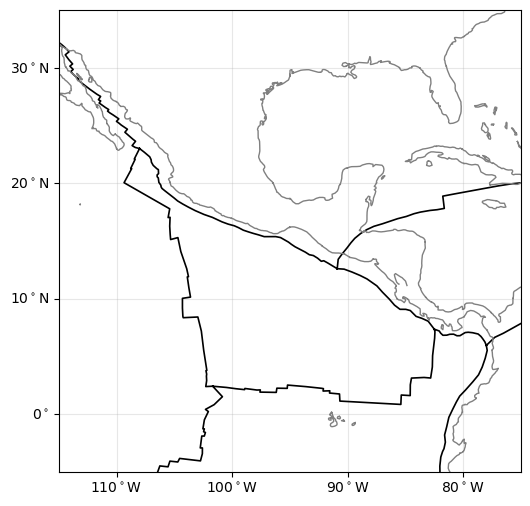

In [5]:
# Create map
fig, ax = basic_map(figsize=(6,6),
                    xlim=(-115, -75),
                    ylim=(-5, 35))

One could take a protractor and measure the angle between North and a ray orthogonal to the Cocos trench. We spice it up and instead plot a ray in our map to visually assess our azimuth. We start by selecting a point somewhere within the Cocos plate, in this case let's choose the point with coordinates (-97.0°E, 10.0°N). We will then start with an assumed angle of 45°, and use the function `shifted_point` to calculate a second point along the ray path of our azimuth. 

Notice that in a map we are looking at a projection of the Earth's surface, so angles are subject to distortion. Since our plate of choice is near the Equator, we safely assume that the distortion is minimal. 

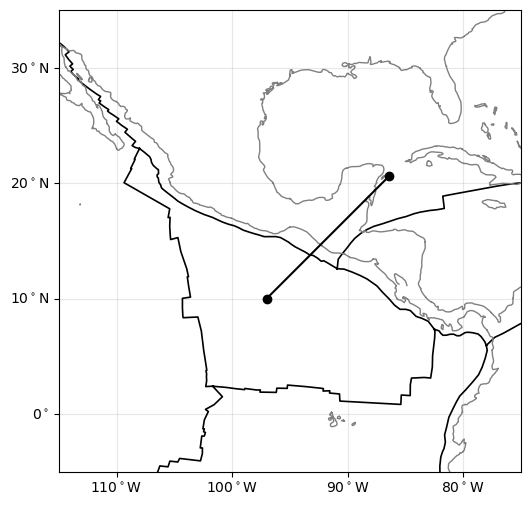

In [36]:
pnt_i_lon, pnt_i_lat = (-97.0, 10.0)   # Initial point of the ray [lon, lat]
dir_azimuth = 45    # Angle of azimuth [degrees], clockwise from North
distance = 15       # Distance between points [degrees]


 # Final point of the ray [lon, lat]
pnt_f_lon, pnt_f_lat = shifted_point(pnt_i_lon, pnt_i_lat, dir_azimuth, distance)  

# Plot line to visually check orthogonality
ax.plot([pnt_i_lon, pnt_f_lon], [pnt_i_lat, pnt_f_lat], '-ok')
fig

Adjust yourself the angle so that you achieve a 90 degree angle between the drawn line and the trench. Remember that plotted lines will stack in the figure. For a fresh start, re-run the cell where the map is created with `basic_map`.

### Euler vector

We move on now to calculate the Euler vector for the present-day motion of the Cocos plate. Ideally we would use the absolute-motion Euler vectors from REBEL (we saw them in exercises 3 and 4), however, this model does not include estimates for the Cocos plate. MORVEL on the other hand, does include relative motion estimates for the Cocos plate: $\omega_{CO/PA}$ and $\omega_{CO/NZ}$. We will do a similar algebraic manipulation as in Exercise 4 to obtain the motion $\omega_{CO/ITRF}$, which is essentially an absolute motion. 

We will also borrow the standarization functions from Exercise 4, `revel_to_cart_degMyr` and `morvel_to_cart_degMyr`.

In [37]:
revel_path = os.path.join(path_to_data, "REVEL_SELLA2002_TABLE3.txt")
revel_ev_df = pd.read_csv(revel_path, delimiter=' ', index_col=0)

morvel_path = os.path.join(path_to_data, "MORVEL_DEMETS2010_TABLE1.txt")
morvel_ev_df = pd.read_csv(morvel_path, delimiter=' ', index_col=0)

In [38]:
def revel_to_cart_degMyr(plate):
    
    # Euler vector from [rad/Myr] to [deg/Myr]
    revel_cart = revel_ev_df.loc[plate][["wX", "wY", "wZ"]] * (180/np.pi)
    return revel_cart

def morvel_to_cart_degMyr(plate_pair):
    
    # Euler vector from spherical to cartesian
    morvel_vec = morvel_ev_df.loc[plate_pair]
    wX, wY, wZ = sph2cart(morvel_vec["lon_degE"], morvel_vec["lat_degN"], morvel_vec["om_degMyr"])
    morvel_cart = pd.Series({"wX": wX, "wY": wY, "wZ": wZ})
    return morvel_cart

Our desired Euler vector can be obtained from the following expression:
$$\omega_{CO/ITRF} = \omega_{CO/PA} -  \omega_{ITRF/PA}$$

Note that we need to invert the reference plate in $\omega_{PA/ITRF}$, which is GENERALLY equivalent to the negative Euler vector. The negative of an Euler vector is the same rotation but in the opposite direction, i.e, we invert the sign of all cartesian components.

$$\omega_{CO/ITRF} = \omega_{CO/PA} - \left(- \omega_{PA/ITRF} \right)$$
$$\omega_{CO/ITRF} = \omega_{CO/PA} + \omega_{PA/ITRF} $$

In [39]:
# Pacific relative to ITRF
ev_PA_ITRF = revel_to_cart_degMyr("Pa")

# Cocos relative to Pacific
ev_CO_PA = morvel_to_cart_degMyr("CO-PA")

We will now combine the two Euler vectors to obtain the absolute motion of Cocos. Know that the two Euler vectors have different time spans (1993-2000 years vs 0-0.78 Myr), so you would normally have to interpolate one of them. We will skip this step, and assume $\omega$ is constant and therefore the rate and pole are valid for the entire time span (i.e. if we were to interpolate, the Euler vector would remain the same). 

In [40]:
# Cocos relative to ITRF
ev_CO_ITRF = ev_CO_PA + ev_PA_ITRF
ev_CO_ITRF

wX   -0.639291
wY   -1.239391
wZ    0.627618
dtype: float64

### Orthogonal surface velocity

Now that we have the azimuth and Euler vector, we can move on to calculate the surface velocity rate orthogonal to the trench. We will use the function `ev_to_surfvel_azimuth` to calculate the velocity. With function requires as input the Euler vector, the azimuth, and the lonlat coordinates of a point in the surface. For our purpose, we should choose a point at roughly the middle of the trench. 

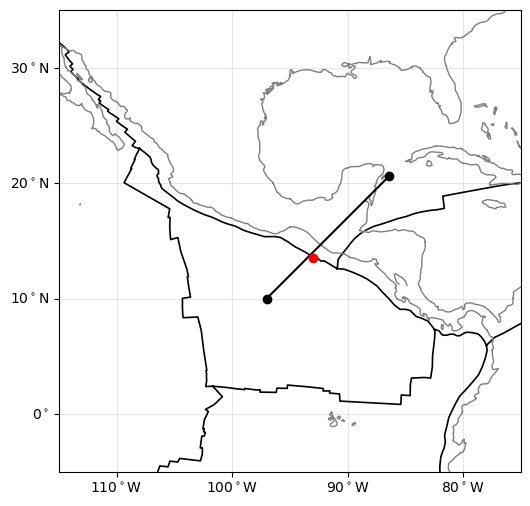

In [50]:
pnt_lon, pnt_lat = (0,0)      # Your choice of coordinates should be near the trench    

# You can check the position of the point in the map (should be a red circle) 
ax.plot(pnt_lon, pnt_lat, 'or')
fig

In [42]:
# Remember you can get help with ?ev_to_surfvel_azimuth, to see what's exactly going on in the function call below.

In [53]:
dir_velocity = ev_to_surfvel_azimuth(ev_CO_ITRF, dir_azimuth, pnt_lon, pnt_lat)
print(f"Velocity along {dir_azimuth}° CW from North: {dir_velocity:.3f} cm/yr")

Velocity along 45° CW from North: 6.975 cm/yr


You can also chosen to use the function `ev_to_surfvel_eastnorth` (already presented in Exercise 3).

### Viscous resistance force

To calculate the viscous resistance force, we will use the expression for $R$ and integrate it. The only caveat is that the viscosity $\mu$ is a dependant of depth ($z$). With pen and paper replace the $\mu(z)$ expression into $R$ and solve the integral. Below you will a function `viscous_resistance` which uses the resulting expression. Check that the expression matches. Alternatively, do the math with pen and paper and compare the resulting force.

In [ ]:
def viscous_resistance(vel_s, theta, D_k, mu_0, z_tip):
    # Make sure you pass SI units! Theta should be in radians
    R = 6371e3
    return (2 * vel_s * mu_0 / (np.sin(theta) * D_k)) * (z_tip - (z_tip**3 / (300 * R)))
    
    
z_array = np.linspace(0, 600e3, 100)
vel_s = dir_velocity / (100 * 365 * 24 * 3600) 
theta = np.radians(30)
z_tip = 300e3
D_k = 100e3
mu_0 = 10e19


resistance_force_permeter = viscous_resistance(vel_s, theta, D_k, mu_0, z_tip)
print(f"Resistance force per meter of trench: {resistance_force_permeter:.2e} N/m")

Resistance force: -1.22e+14 N


Now, we need the length of the trench to calculate the actual force in Newtons. You have at least two options: 

a) Visually estimate the length in degrees and convert it to meters using the knowledge that 1 degree is approximately 111 km. 

b) Identify in the map the coordinates of the two ends of the trench and use the function `geodesic_distance` to calculate the distance in meters.

In [ ]:
from map_dependencies import geodesic_distance

# Replace the parameters with your coordinates
trench_length = geodesic_distance(point1_lon, point1_lat, 
                                  point2_lon, point2_lat)


resistance_force = resistance_force_permeter * trench_length
print(f"Resistance force: {resistance_force_permeter:.2e} N")
